## Demo for the multivariate 'arch' toolbox



This files provides a demo for the fast implementation of the Multivariate extension for the 'arch' toolbox. It uses the Oxford-Man realized volatility library of Heber et. al 2009, version 0.3:

Heber, Gerd, Asger Lunde, Neil Shephard and Kevin K. Sheppard (2009) "Oxford-Man Institute's realized library", Oxford-Man Institute, University of Oxford.

The demo estimates and forecasts the volatility of daily returns for the FTSE100, the Nikkei and the S&P500 using a multivariate DCCA specification based on univariate GARCH processes.

Let's start by importing the existing `arch` toolbox's implementation of the univeriate GARCH model and the `mArch` toolbox itself. `pandas` is not required for estimation (a `numpy` array would work fine), but simplifies the handling of the underlying dataset.

In [1]:
import pandas as pd

from mArch import mArch
from arch.univariate import GARCH
from matplotlib import pyplot as plt

We also specify a few parameters

In [2]:
# Set some parameters
dataPath = 'data/oxfordmanrealizedvolatilityindices.csv' # path to the dataset
indList = ['.SPX', '.FTSE', '.N225']     # Database indices to extract the data
numObs = 2700                            # Number of observations to include in estimation
splitObs = 2500                          # Split for the training/forecasting data

# Plot parameters
fontSize = 12
y_min = -12
y_max = 12

### Data extraction and visualisation

Let's load the raw data, extract the data required for the estimation, and plot the daily returns for the series to visualise the empirical data

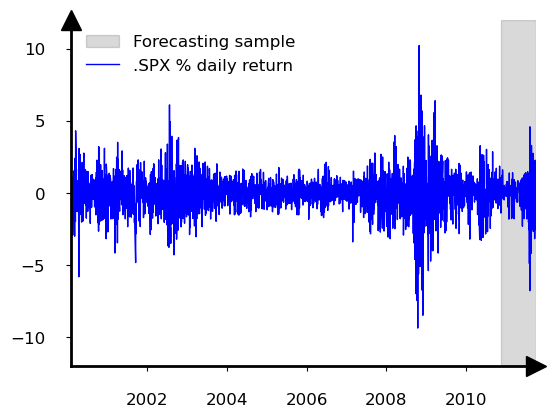

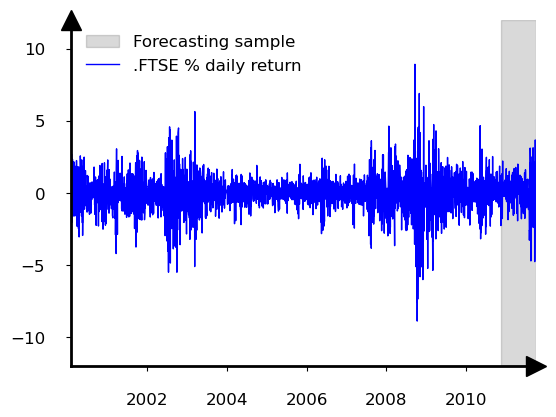

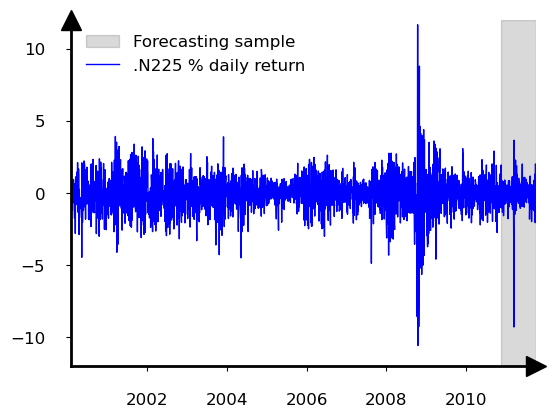

In [3]:
# Load dataset, extract indices, format data
data = pd.read_csv(dataPath, index_col=[0])

for count,ind in enumerate(indList):
    if count == 0:
        mRt = pd.DataFrame(          # Daily returns (for sign)
                data[data.Symbol == ind]['open_to_close']
                ).rename(columns={"open_to_close": ind})

    else:
        mRt = mRt.merge(pd.DataFrame(
            data[data.Symbol == ind]['open_to_close']
            ).rename(columns={"open_to_close": ind}),
                        how='inner', 
                        left_index = True, 
                        right_index = True)
mRt *= 100                              # Rescale to % from raw log-returns
mRt.index = pd.to_datetime(mRt.index)   # Change index to datetime for plot

# Plot the data
for ind in indList:
    xlim_left = mRt.index[0]
    xlim_right = mRt.index[numObs]
        
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.fill([mRt.index[splitObs],
             xlim_right,
             xlim_right,
             mRt.index[splitObs]], 
            [y_min,y_min,y_max,y_max], 
            color = 'k', alpha=0.15, label = r'Forecasting sample')
    ax.plot(mRt.index[0:numObs], mRt.iloc[0:numObs][ind], 
            'b', linewidth=1,label =  '{:s} % daily return'.format(ind))
    ax.set_ylim([y_min,y_max])
    ax.legend(loc='upper left', frameon=False, prop={'size':fontSize})
    ax.set_ylim(top = y_max, bottom = y_min)
    ax.set_xlim(left = xlim_left,right = xlim_right)
    ax.plot(xlim_right, y_min, ">k", ms=15, clip_on=False)
    ax.plot(xlim_left, y_max, "^k", ms=15, clip_on=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='x', pad=15, labelsize=fontSize)
    ax.tick_params(axis='y', pad=15, labelsize=fontSize)


### Multivariate GARCH estimation

We initialise a multivariate `arch` estimation by providing the empirical dataset to an instance of the mArch object

In [4]:
mArchEst = mArch(mRt.iloc[0 : numObs])

The estimation itself is setup by providing the univariate specification, the error type and the multivariate specification. Here we use a GARCH to model the univivariate volatility process, but any univariate process from the `arch` toolbox can be used, as long as it is imported in the file header. Similarly, this demo uses a Assymmetric Dynamic Conditional Correlation (DCCA) model for the correlation between series, but can also use a Constant conditional Correlation (CCC) model, or a Dynamic Conditional Correlation (DCC) with no asymmetric response to shocks. Innovations can either be normally distributed, or follow a Student t.

In [5]:
univarSpec = GARCH(p = 2, q = 2, o = 1, power = 2)
mArchEst.setArch(univarSpec,
                 errors = 'Student', 
                 multivar = 'dcca')

We then run the estimation with a user-provided starting point for the DCCA parameters. The toolbox provides default values, but also allows for user-provided values in case of non-convergence of the estimation.

In [6]:
initVals = [0.05, 0.9, 0.05 ,7]
mArchEst.fit(update_freq = 0, 
             last_obs = splitObs,
             init = initVals)

Univariate estimation of .SPX
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3596.094799301708
            Iterations: 13
            Function evaluations: 116
            Gradient evaluations: 13
Univariate estimation of .FTSE
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3538.4923693508854
            Iterations: 16
            Function evaluations: 143
            Gradient evaluations: 16
Univariate estimation of .N225
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3704.388284178703
            Iterations: 15
            Function evaluations: 138
            Gradient evaluations: 15
Covariance process estimation - dcca


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 21392.691834741592
       x: [ 1.009e-02  3.925e-01  1.347e-10  9.362e+00]
     nit: 18
     jac: [ 3.320e-02  0.000e+00  1.611e+02  1.465e-03]
    nfev: 96
    njev: 18

Once the estimation has run we can check that the boundary condition for the DCCA model holds (ensuring positive-definite correlation matrices) and print the estimation summary. This provides the `arch` summary for the individual series estimation, as well as a summary of the multivariate correlation process estimation.

In [7]:
mArchEst.checkBoundary()
mArchEst.summary()

Parameter boundary condition for dcca is  met:
 Condition value: 5.973848e-01
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   .SPX   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3596.09
Distribution:                  Normal   AIC:                           7206.19
Method:            Maximum Likelihood   BIC:                           7246.96
                                        No. Observations:                 2500
Date:                Thu, Jul 18 2024   Df Residuals:                     2499
Time:                        17:33:28   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------

Finally, the `mArch` toolbox allows for forecasting (5 days-ahead here), using the same syntax as the `arch` toolbox.

In [8]:
forecastMethod = 'simulation'
Hpred = mArchEst.forecast(horizon = 5, 
                          start = splitObs, 
                          method = forecastMethod)